# 데이터 전처리 파이프라인

## 1. 필요한 라이브러리 임포트 및 기본 설정

In [20]:
# 필요한 라이브러리 임포트
import os
import json
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# 데이터 증강을 위한 Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 Matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import copy

# Matplotlib 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"경고: 한글 폰트 설정 중 오류 발생 ({e}). 폰트 설정에 문제가 있을 수 있습니다.")

print("\n데이터 전처리 라이브러리 임포트 완료")


데이터 전처리 라이브러리 임포트 완료


## 2. EDA에서 생성된 데이터프레임 사용 준비

EDA 과정에서 생성된 annotations_df, images_df, global_categories_df 변수들을 전처리 파이프라인에 활용할 준비를 합니다. 이 단계에서는 특히 클래스 ID와 이름 간의 매핑을 설정하고, annotations_df에 최종 모델이 사용할 class_id 컬럼을 추가합니다.

In [114]:
# 데이터셋 경로 설정
DATA_ROOT = '../data/raw' # 사용자 환경에 맞게 조정
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations')
TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')

print(f"TRAIN_IMG_DIR: {TRAIN_IMG_DIR}")
print(f"TRAIN_ANNO_DIR: {TRAIN_ANNO_DIR}")
print(f"TEST_IMG_DIR: {TEST_IMG_DIR}")

# 디렉토리 존재 여부 확인 및 입력 유도
if not os.path.exists(TRAIN_IMG_DIR) or not os.path.exists(TRAIN_ANNO_DIR) or not os.path.exists(TEST_IMG_DIR):
    print("현재 설정된 경로 중 하나 이상을 찾을 수 없습니다.")
    
    suggested_root = input("올바른 DATA_ROOT 경로를 입력하세요: ")
    if os.path.exists(os.path.join(suggested_root, 'train_images')):
        DATA_ROOT = suggested_root
        TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
        TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations')
        TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')
        print(f"경로가 '{DATA_ROOT}'(으)로 업데이트 되었습니다. 계속 진행합니다.")
    else:
        print("입력된 경로도 유효하지 않아 프로그램을 종료합니다. 경로를 다시 확인해주세요.")
        exit() # 경로 문제로 EDA 진행 불가 시 종료

TRAIN_IMG_DIR: ../data/raw/train_images
TRAIN_ANNO_DIR: ../data/raw/train_annotations
TEST_IMG_DIR: ../data/raw/test_images


In [105]:
# --- JSON 파일을 재귀적으로 탐색하는 헬퍼 함수 ---
def find_json_files_recursively(root_dir):
    json_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.json'):
                json_files.append(os.path.join(dirpath, filename))
    return json_files

# 파일 개수 세기
train_image_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.png')]
train_annotation_full_paths = find_json_files_recursively(TRAIN_ANNO_DIR)
test_image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.png')]

print(f"총 훈련 이미지 개수: {len(train_image_files)}")
print(f"총 훈련 어노테이션 파일 개수: {len(train_annotation_full_paths)}")
print(f"총 테스트 이미지 개수: {len(test_image_files)}")

if len(train_image_files) > 0 and len(train_annotation_full_paths) > 0:
    print("\n훈련 이미지와 어노테이션 파일이 모두 존재하는 것을 확인했습니다. 파싱 단계에서 정확한 매칭을 수행합니다.")
else:
    print("\n훈련 이미지 또는 어노테이션 파일이 충분하지 않아 보입니다. 확인이 필요합니다.")

총 훈련 이미지 개수: 651
총 훈련 어노테이션 파일 개수: 1001
총 테스트 이미지 개수: 843

훈련 이미지와 어노테이션 파일이 모두 존재하는 것을 확인했습니다. 파싱 단계에서 정확한 매칭을 수행합니다.


In [106]:
all_images_meta = [] # 각 이미지의 메타데이터 (약 종류, 모양, 색상 등)
all_annotations = [] # 각 바운딩 박스 정보
all_category_mappings = [] # 모든 JSON 파일에서 발견된 category-id-name 매핑

print("훈련 어노테이션 파일 파싱 중...")
# 중복 image_file_name, annotation_id, category_id-name 쌍 처리를 위한 집합
parsed_image_filenames_set = set() # images['file_name'] 기준으로 중복 제거
parsed_annotation_ids_set = set()
parsed_category_id_name_pairs_set = set()

for full_path in tqdm(train_annotation_full_paths, desc="Parsing Annotations"):
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"경고: {full_path} 파일 파싱 중 오류 발생: {e}. 건너뜁니다.")
        continue
    except Exception as e:
        print(f"경고: {full_path} 파일 로드 중 예외 발생: {e}. 건너뜁니다.")
        continue

    # 'images' 섹션 처리
    if 'images' in data:
        for img_info in data['images']:
            if img_info['file_name'] not in parsed_image_filenames_set:
                img_info['source_json_file'] = full_path # 어떤 JSON 파일에서 왔는지 기록
                all_images_meta.append(img_info)
                parsed_image_filenames_set.add(img_info['file_name'])
    
    # 'annotations' 섹션 처리
    if 'annotations' in data:
        for anno_info in data['annotations']:
            # 'bbox' 유효성 검증 및 annotation ID 중복 방지
            if ('bbox' in anno_info and anno_info['bbox'] and len(anno_info['bbox']) == 4 and
                anno_info['id'] not in parsed_annotation_ids_set):
                anno_info['source_json_file'] = full_path
                all_annotations.append(anno_info)
                parsed_annotation_ids_set.add(anno_info['id'])

    # 'categories' 섹션 처리
    if 'categories' in data:
        for cat_info in data['categories']:
            # (id, name) 쌍으로 고유성 관리하여 중복 추가 방지
            cat_id_name_pair = (cat_info['id'], cat_info['name'])
            if cat_id_name_pair not in parsed_category_id_name_pairs_set:
                all_category_mappings.append(cat_info)
                parsed_category_id_name_pairs_set.add(cat_id_name_pair)

# DataFrame 생성
images_df = pd.DataFrame(all_images_meta)
annotations_df = pd.DataFrame(all_annotations)
categories_df = pd.DataFrame(all_category_mappings)

print("\n파싱 완료")
print(f"이미지 메타데이터 (images_df) 개수: {len(images_df)}")
print(f"어노테이션 (annotations_df) 개수: {len(annotations_df)}")
print(f"총 고유 카테고리 (categories_df) 개수: {len(categories_df)}")

# 어노테이션에 이미지 메타데이터 정보 병합
# `annotations_df`의 `image_id`와 `images_df`의 `id`를 기준으로 병합
annotations_df = pd.merge(annotations_df, 
                          images_df[['id', 'file_name', 'dl_name', 'drug_shape', 'color_class1', 
                                     'back_color', 'light_color', 'print_front', 'dl_idx']], 
                          left_on='image_id', right_on='id', how='left', suffixes=('_anno', '_img'))

# 중복된 'id_img' 컬럼은 제거 (annotations_df에 'image_id'가 이미 있으므로)
annotations_df.drop(columns=['id_img'], inplace=True)

# 최종 글로벌 카테고리 매핑 테이블 생성 (categories_df의 id와 name 사용)
global_categories_df = categories_df[['id', 'name']].copy()
global_categories_df.rename(columns={'id': 'global_category_id', 'name': 'global_class_name'}, inplace=True)

print(f"\n최종 통합된 고유 알약 클래스 개수 (global_categories_df): {len(global_categories_df)}개")

# 어노테이션 DataFrame에 최종 global_class_name 추가 (category_id는 이미 글로벌 ID와 동일함)
annotations_df = pd.merge(annotations_df, global_categories_df[['global_category_id', 'global_class_name']], 
                          left_on='category_id', right_on='global_category_id', how='left')
annotations_df.drop(columns=['global_category_id'], inplace=True) # 중복 컬럼 제거 (annotations_df에는 category_id가 이미 있음)

# 이미지 폴더와 JSON 어노테이션 간의 불일치 여부 확인 및 필터링
all_train_image_filenames = set([os.path.basename(f) for f in train_image_files])
parsed_image_filenames_from_json = set(images_df['file_name'].tolist())

# 유효한 이미지 파일명: 폴더에도 있고, JSON에도 언급된 파일명만
valid_image_filenames = all_train_image_filenames.intersection(parsed_image_filenames_from_json)

unmatched_images_in_folder = all_train_image_filenames - valid_image_filenames
unmatched_images_in_json = parsed_image_filenames_from_json - valid_image_filenames

if len(unmatched_images_in_folder) > 0:
    print(f"\n경고: {len(unmatched_images_in_folder)}개의 이미지 파일은 폴더에 있지만, JSON 어노테이션에 언급되지 않았습니다.")
    print(f"일부 불일치 이미지 파일: {list(unmatched_images_in_folder)[:5]}")
if len(unmatched_images_in_json) > 0:
    print(f"\n경고: {len(unmatched_images_in_json)}개의 이미지 파일은 JSON 어노테이션에는 언급되었지만, 실제 폴더에는 존재하지 않습니다.")
    print(f"일부 불일치 이미지 파일: {list(unmatched_images_in_json)[:5]}")

if len(unmatched_images_in_folder) == 0 and len(unmatched_images_in_json) == 0:
    print("\n모든 이미지 파일이 JSON 어노테이션에 정확히 매칭됩니다.")
else:
    print("\n이미지 파일과 JSON 어노테이션 간의 불일치가 있습니다. 학습 데이터 필터링을 진행합니다.")

# images_df와 annotations_df를 유효한 파일명 기준으로 필터링
images_df = images_df[images_df['file_name'].isin(valid_image_filenames)].reset_index(drop=True)

# annotations_df는 image_id를 images_df에서 가져오므로, images_df 필터링 후 다시 병합하는 것이 안전
annotations_df = annotations_df[annotations_df['file_name'].isin(valid_image_filenames)].reset_index(drop=True)

print(f"\n최종 필터링 후 학습에 사용 가능한 이미지 개수 (images_df): {len(images_df)}개")
print(f"최종 필터링 후 학습에 사용 가능한 어노테이션 개수 (annotations_df): {len(annotations_df)}개")


훈련 어노테이션 파일 파싱 중...


Parsing Annotations:   0%|          | 0/1001 [00:00<?, ?it/s]


파싱 완료
이미지 메타데이터 (images_df) 개수: 369
어노테이션 (annotations_df) 개수: 1001
총 고유 카테고리 (categories_df) 개수: 56

최종 통합된 고유 알약 클래스 개수 (global_categories_df): 56개

경고: 419개의 이미지 파일은 폴더에 있지만, JSON 어노테이션에 언급되지 않았습니다.
일부 불일치 이미지 파일: ['K-003483-022347-027733-029667_0_2_0_2_70_000_200.png', 'K-003544-004543-012247-016551_0_2_0_2_75_000_200.png', 'K-002483-005094-012081-012778_0_2_0_2_70_000_200.png', 'K-003483-016262-027733-028763_0_2_0_2_90_000_200.png', 'K-003544-006563-010221-016551_0_2_0_2_90_000_200.png']

경고: 137개의 이미지 파일은 JSON 어노테이션에는 언급되었지만, 실제 폴더에는 존재하지 않습니다.
일부 불일치 이미지 파일: ['K-003351-032310-035206_0_2_0_2_70_000_200.png', 'K-003351-018147-021325_0_2_0_2_70_000_200.png', 'K-003351-016688-019232_0_2_0_2_75_000_200.png', 'K-003351-016232-033880_0_2_0_2_90_000_200.png', 'K-003351-019232-021325_0_2_0_2_70_000_200.png']

이미지 파일과 JSON 어노테이션 간의 불일치가 있습니다. 학습 데이터 필터링을 진행합니다.

최종 필터링 후 학습에 사용 가능한 이미지 개수 (images_df): 232개
최종 필터링 후 학습에 사용 가능한 어노테이션 개수 (annotations_df): 763개


In [107]:
# 필요한 데이터프레임 및 변수들이 있는지 확인
required_vars = ['annotations_df', 'images_df', 'global_categories_df', 'TRAIN_IMG_DIR']
for var_name in required_vars:
    if var_name not in globals():
        raise RuntimeError(f"오류: '{var_name}' 변수가 로드되어 있지 않습니다. EDA 코드를 먼저 실행하여 데이터를 로드해주세요.")
print("EDA에서 로드된 데이터프레임 확인 완료")

# 클래스 ID와 이름 매핑 딕셔너리 생성
# `global_categories_df`의 실제 컬럼명 (`global_category_id`와 `global_class_name`)을 사용
class_name_to_id = {name: int(cid) for cid, name in zip(global_categories_df['global_category_id'], global_categories_df['global_class_name'])}
category_id_to_name = {int(cid): name for cid, name in zip(global_categories_df['global_category_id'], global_categories_df['global_class_name'])}

# annotations_df에 모델이 사용할 최종 class_id 추가
annotations_df['class_id'] = annotations_df['category_id']

# 훈련(train) 및 검증(validation) 데이터셋 준비
# 여기서는 예시를 위해 `annotations_df` 전체를 훈련/검증 데이터로 사용
train_df = annotations_df.copy()
val_df = annotations_df.copy()

print("\n데이터 전처리 준비 완료")
print(f"총 고유 클래스 수: {len(class_name_to_id)}")
print(f"클래스 ID 매핑 예시: {list(class_name_to_id.items())[:5]}")
print("\n전처리 대상 annotations_df 헤드:")
print(annotations_df.head())

EDA에서 로드된 데이터프레임 확인 완료

데이터 전처리 준비 완료
총 고유 클래스 수: 56
클래스 ID 매핑 예시: [('일양하이트린정 2mg', 3350), ('글리아타민연질캡슐', 32309), ('플라빅스정 75mg', 20237), ('종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', 18356), ('리피토정 20mg', 16231)]

전처리 대상 annotations_df 헤드:
    area  iscrowd                  bbox  category_id  ignore segmentation  \
0  33672        0  [403, 226, 184, 183]         3350       0           []   
1  37442        0  [385, 859, 193, 194]         3350       0           []   
2  98612        0  [560, 715, 277, 356]        32309       0           []   
3  87316        0  [151, 231, 263, 332]        32309       0           []   
4  49950        0  [144, 800, 225, 222]        20237       0           []   

   id_anno  image_id                                   source_json_file  \
0     3098       816  ../data/raw/train_annotations/K-003351-020238-...   
1     3096       814  ../data/raw/train_annotations/K-003351-020238-...   
2     3092       816  ../data/raw/train_annotations/K-003351-020238-...   
3     3090   

## 3. 데이터 증강 (Data Augmentation) 파이프라인 정의

Albumentations 라이브러리를 사용하여 훈련 데이터에 적용될 데이터 증강 파이프라인과 검증 데이터에 적용될 기본 변환 파이프라인을 정의합니다. 이때 bbox_params는 format='coco'로 설정하여 Albumentations가 픽셀 단위로 바운딩 박스를 안정적으로 변환하고 클리핑하도록 합니다.

In [108]:
# 모델 입력 이미지의 최종 크기 정의 (가로, 세로)
TARGET_IMAGE_SIZE = (640, 640)

def get_train_transform(target_size=TARGET_IMAGE_SIZE):
    """
    훈련 데이터셋에 적용할 Albumentations 데이터 증강 파이프라인 정의
    Albumentations는 이미지와 COCO 포맷 바운딩 박스를 변환하며, 최종 YOLOv8 포맷 변환은 PillYoloDataset에서 수동 처리
    """
    return A.Compose([
        A.HorizontalFlip(p=0.5), # 좌우 반전 
        
        # 색상 관련 증강 (바운딩 박스에 영향 없음)
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3), # 밝기/대비 변화
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3), # 색조/채도/값 변화
        A.Blur(blur_limit=3, p=0.1), # 블러 효과
        A.GaussNoise(p=0.1), # 가우시안 노이즈 추가
        A.MotionBlur(blur_limit=3, p=0.1), # 모션 블러 추가
        A.RandomGamma(p=0.2), # 감마 값 변경

        # --- 리사이징 및 패딩 (종횡비 유지 "Letterbox" 방식) ---
        # 이미지의 종횡비를 유지하면서 지정된 target_size에 맞춰 리사이징하고, 남은 공간은 패딩으로 채움
        A.LongestMaxSize(max_size=max(target_size), p=1.0),
        A.PadIfNeeded(
            min_height=target_size[1],
            min_width=target_size[0],
            border_mode=cv2.BORDER_CONSTANT,
            fill_value=(0,0,0), 
            p=1.0
        ),
        
        # --- 픽셀 값 정규화 및 PyTorch 텐서 변환 ---
        A.Normalize( # 픽셀 값을 0-1 범위로 정규화
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2(p=1.0) # NumPy 배열을 PyTorch Tensor (CxHxW)로 변환
    ], 
    bbox_params=A.BboxParams( # 바운딩 박스 변환 설정 (format='coco'로 픽셀 단위 처리)
        format='coco',        # Albumentations는 COCO 픽셀 포맷으로 처리
        label_fields=['class_labels'],
        min_area=1.0,         # 변환 후 면적이 1.0 픽셀 미만인 바운딩 박스 제거
        min_visibility=0.0,   # 보이는 부분이 0% 미만인 바운딩 박스 제거 (즉, 완전히 이미지 밖으로 나가면 제거)
        clip=True,            # 이미지 경계 밖으로 벗어나지 않도록 클리핑 (픽셀 단위로)
        min_width=1,          # 너비가 1픽셀 미만인 바운딩 박스 제거
        min_height=1          # 높이가 1픽셀 미만인 바운딩 박스 제거
    ))

def get_val_transform(target_size=TARGET_IMAGE_SIZE):
    """
    검증 및 테스트 데이터셋에 적용할 Albumentations 변환 파이프라인을 정의
    훈련과 달리 증강은 포함하지 않고, 이미지 크기 조정 및 정규화만 수행
    """
    return A.Compose([
        A.LongestMaxSize(max_size=max(target_size), p=1.0),
        A.PadIfNeeded(
            min_height=target_size[1],
            min_width=target_size[0],
            border_mode=cv2.BORDER_CONSTANT,
            fill_value=(0,0,0), 
            p=1.0
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2(p=1.0)
    ], 
    bbox_params=A.BboxParams( # format='coco'로
        format='coco',
        label_fields=['class_labels'],
        min_area=1.0,
        min_visibility=0.0,
        clip=True,
        min_width=1,
        min_height=1
    ))

print("Albumentations 트랜스폼 파이프라인 정의 완료")

Albumentations 트랜스폼 파이프라인 정의 완료


## 4. PyTorch Dataset 클래스 구현 (YOLOv8 최적화)

PillYoloDataset 클래스는 PyTorch Dataset 인터페이스를 구현하여 YOLOv8 모델 학습에 필요한 데이터를 제공합니다. 이 클래스는 다음 역할을 수행합니다:

- 이미지를 로드하고 Albumentations로 변환합니다.
- Albumentations로부터 COCO 픽셀 포맷으로 변환된 바운딩 박스를 받습니다.
- 이 COCO 포맷 바운딩 박스를 최종 변환된 이미지 크기를 기준으로 YOLO 포맷([cx, cy, norm_w, norm_h], 0~1 정규화)으로 수동 변환하고, 최종적으로 유효하지 않은 바운딩 박스를 필터링합니다.
- __getitem__ 메서드 내부에 견고한 오류 처리 및 재시도 로직을 포함하여 데이터 로딩 실패 시 학습이 중단되지 않도록 합니다.

In [118]:
class PillYoloDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_dir: str, transforms=None):
        """
        YOLOv8 모델 학습을 위한 데이터셋 클래스.
        
        Args:
            df (pd.DataFrame): 이미지별 어노테이션 정보를 담고 있는 DataFrame.
                               'image_id', 'file_name', 'bbox', 'class_id' 컬럼 포함.
            img_dir (str): 이미지가 저장된 디렉토리 경로.
            transforms (albumentations.Compose): 이미지 및 바운딩 박스 변환을 위한 Albumentations 파이프라인.
        """
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = df['image_id'].unique()
        self.grouped_df = df.groupby('image_id')
        self.error_count = 0
        self.max_retries = 10 # 실패한 경우 최대 10번까지 다른 샘플 시도

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, tuple[int, int]]:
        """
        주어진 인덱스(idx)에 해당하는 이미지와 어노테이션을 로드하고 변환하여 반환
        YOLOv8 모델 학습에 적합한 형태로 데이터를 반환
        
        Returns:
            tuple[torch.Tensor, torch.Tensor, tuple[int, int]]:
                - image (torch.Tensor): 변환된 이미지 텐서 (CxHxW), 0-1 범위.
                - labels (torch.Tensor): N개의 바운딩 박스에 대한 `[class_id, cx, cy, w, h]` 형태의 텐서 (모두 0-1 정규화).
                                         N개의 객체가 있다면 `(N, 5)` 형태.
                - original_size (tuple): 변환 전 이미지의 `(원본 높이, 원본 너비)`.
        """
        for _ in range(self.max_retries): # 오류 발생 시 max_retries 횟수만큼 재시도
            try:
                current_image_idx = idx # 현재 시도하는 이미지의 원래 인덱스 저장
                image_id = self.image_ids[current_image_idx]
                image_annotations = self.grouped_df.get_group(image_id)

                file_name = image_annotations['file_name'].iloc[0]
                image_path = os.path.join(self.img_dir, file_name)

                # 이미지 로드 (OpenCV로 로드 후 BGR -> RGB 변환)
                image = cv2.imread(image_path)
                if image is None:
                    raise FileNotFoundError(f"오류: 이미지 파일을 찾을 수 없습니다: {image_path}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                original_height, original_width = image.shape[:2]

                # 바운딩 박스 추출 (COCO 형식: [x_min, y_min, width, height], 픽셀 단위)
                raw_bboxes = np.array(image_annotations['bbox'].tolist(), dtype=np.float32)

                # 클래스 라벨 추출 (모델이 사용할 최종 class_id)
                raw_class_labels = image_annotations['class_id'].values.tolist()
                
                # 정의된 Albumentations Transforms 적용 (이미지와 바운딩 박스 모두)
                if self.transforms:
                    transformed = self.transforms(image=image, bboxes=raw_bboxes, class_labels=raw_class_labels,
                                                  height=original_height, width=original_width)
                    image_transformed = transformed['image']
                    # Albumentations로부터 COCO 픽셀 포맷으로 변환된 Bbox와 라벨을 받음
                    transformed_bboxes_coco = np.array(transformed['bboxes'], dtype=np.float32) 
                    transformed_class_labels = np.array(transformed['class_labels'], dtype=np.float32)
                else: # transforms가 없을 때 (예: 검증 시)
                    image_transformed = image.astype(np.float32) / 255.0 # 0-1 정규화
                    image_transformed = torch.from_numpy(image_transformed).permute(2, 0, 1) # HWC -> CHW
                    transformed_bboxes_coco = raw_bboxes # 변환 없으니 원본 COCO 픽셀 Bbox 그대로 사용
                    transformed_class_labels = np.array(raw_class_labels, dtype=np.float32)

                # Albumentations로 인해 변경된 최종 이미지의 크기
                # image_transformed가 CxHxW 형태이므로, 높이와 너비는 1,2 인덱스
                final_image_h, final_image_w = image_transformed.shape[1], image_transformed.shape[2] 
                
                bboxes_yolo = []
                filtered_class_labels_final = [] # 최종 필터링된 클래스 라벨
                
                for i, bbox_coco in enumerate(transformed_bboxes_coco):
                    xmin, ymin, w, h = bbox_coco
                    
                    # COCO 픽셀 바운딩 박스 `[xmin, ymin, w, h]`를 YOLO 정규화 포맷 `[cx, cy, norm_w, norm_h]`로 변환
                    # 최종 변환된 이미지 크기 (`final_image_w`, `final_image_h`)를 기준으로 정규화
                    cx = (xmin + w / 2.0) / final_image_w
                    cy = (ymin + h / 2.0) / final_image_h
                    norm_w = w / final_image_w
                    norm_h = h / final_image_h

                    # 수동 유효성 검사 및 필터링 (최종 YOLO Bbox에 대해)
                    # 변환 후에도 너비/높이가 극히 작거나 유효하지 않은 바운딩 박스 제거
                    if norm_w > 1e-6 and norm_h > 1e-6: # 아주 작은 너비/높이도 일단 허용 (정규화된 값 기준)
                        # 정규화된 값 범위 클리핑
                        cx = np.clip(cx, 0.0, 1.0)
                        cy = np.clip(cy, 0.0, 1.0)
                        norm_w = np.clip(norm_w, 0.0, 1.0)
                        norm_h = np.clip(norm_h, 0.0, 1.0)

                        bboxes_yolo.append([cx, cy, norm_w, norm_h])
                        filtered_class_labels_final.append(transformed_class_labels[i])
                    # else:
                        # print(f"DEBUG: 필터링된 무효 Bbox: {bbox_coco} (Image ID: {image_id}) after Albumentations, before YOLO norm")

                bboxes_yolo = np.array(bboxes_yolo, dtype=np.float32)
                
                if len(bboxes_yolo) > 0:
                    labels_tensor = torch.cat((torch.tensor(filtered_class_labels_final, dtype=torch.float32).unsqueeze(1),
                                               torch.tensor(bboxes_yolo, dtype=torch.float32)), dim=1)
                else:
                    labels_tensor = torch.empty((0, 5), dtype=torch.float32) # 객체가 없으면 빈 (0, 5) 텐서

                # YOLOv8 모델 입력에 맞는 형태로 이미지 텐서, 라벨 텐서, 원본 이미지 크기 반환
                return image_transformed, labels_tensor, (original_height, original_width)
                
            except Exception as e: # FileNotFoundError 포함 모든 종류의 예외를 처리 (견고성 확보)
                self.error_count += 1
                
                print(f"데이터 로딩 중 오류 발생 (에러 카운트: {self.error_count}): 이미지 ID {image_id}, 파일 {file_name}")
                print(f"원본 HxW: {original_height}x{original_width}")
                print(f"Albumentations에 전달된 (raw) bboxes: {raw_bboxes.tolist()}") 
                print(f"오류 메시지: {e}")
                
                # 다음 이미지로 idx를 업데이트 (데이터셋 전체를 순환)
                idx = (idx + 1) % len(self.image_ids)
                if self.error_count % 1 == 0: # 오류 발생 시 매번 로그 출력
                    print(f"현재까지 {self.error_count}개의 샘플에서 오류 발생. 다음 샘플 시도 중.")
        
        # max_retries를 모두 소진했음에도 유효한 샘플을 찾지 못한 경우 RuntimeError 발생
        raise RuntimeError(f"{self.max_retries}번의 재시도 후에도 유효한 샘플을 찾을 수 없습니다. 데이터셋 확인 필요.")

print("PillYoloDataset 클래스 정의 완료")

PillYoloDataset 클래스 정의 완료


## 5. collate_fn_yolo 구현 (YOLOv8 배치 처리)

collate_fn_yolo 함수는 PyTorch DataLoader가 YOLOv8 모델의 입력 요구사항에 맞춰 배치 데이터를 구성하도록 돕습니다. 이미지 배치는 BxCxHxW 형태로 스택하고, 라벨 배치는 모든 객체의 정보를 하나의 텐서로 합쳐 N_total x [batch_idx, class_id, cx, cy, w, h] 형태로 만듭니다.

In [116]:
def collate_fn_yolo(batch: list) -> tuple[torch.Tensor, torch.Tensor, list[tuple[int, int]]]:
    """
    YOLOv8의 DataLoader에 맞는 `collate_fn` 구현.
    이미지 텐서들을 배치로 묶고, 라벨 텐서들을 합쳐 `[batch_idx, class_id, cx, cy, w, h]` 형태로 만듦
    
    Args:
        batch (list): `(image, labels_tensor, original_size)` 튜플의 리스트.
                      - `image`: `torch.Tensor` (CxHxW)
                      - `labels_tensor`: `torch.Tensor` (N, 5) => `[class_id, cx, cy, w, h]`
                      - `original_size`: `tuple[int, int]` (height, width)

    Returns:
        tuple[torch.Tensor, torch.Tensor, list[tuple[int, int]]]:
            - `images_batch` (torch.Tensor): 배치 이미지 텐서 (BxCxHxW).
            - `labels_batch` (torch.Tensor): 모든 이미지의 라벨을 합친 텐서 (N_total, 6) => `[batch_idx, class_id, cx, cy, w, h]`.
            - `original_sizes_batch` (list): 배치 내 모든 이미지의 원본 크기 리스트.
    """
    # `__getitem__`에서 반환하는 세 가지 요소를 분리하여 리스트로 만듦
    images, labels_list, original_sizes = zip(*batch) # (image, labels_tensor, original_size)
    
    # 이미지 텐서들을 배치로 묶기 (torch.stack)
    images_batch = torch.stack(images, 0)

    # 라벨들을 배치로 묶기: 각 라벨에 해당 이미지의 `batch_idx`를 추가
    batched_labels = []
    for i, labels_per_image in enumerate(labels_list):
        if labels_per_image.numel() == 0: # 라벨이 없는 이미지(객체 0개)는 건너뜀
            continue
        # `[batch_idx, class_id, cx, cy, w, h]` 형태로 변환하기 위해 `batch_idx` 컬럼을 앞에 추가
        batch_idx_tensor = torch.full((labels_per_image.shape[0], 1), i, dtype=torch.float32)
        batched_labels.append(torch.cat((batch_idx_tensor, labels_per_image), dim=1))
    
    if len(batched_labels) > 0:
        labels_batch = torch.cat(batched_labels, 0)
    else:
        labels_batch = torch.empty((0, 6), dtype=torch.float32) # 모든 배치에 객체가 없다면 빈 (0, 6) 텐서

    return images_batch, labels_batch, list(original_sizes) # original_sizes도 리스트로 반환

print("collate_fn_yolo 정의 완료")

collate_fn_yolo 정의 완료


## 6. Dataset 및 DataLoader 인스턴스 생성 및 사용 예시 (YOLOv8 버전)

정의된 PillYoloDataset 클래스와 collate_fn_yolo를 사용하여 DataLoader 인스턴스를 생성하고, 실제로 첫 번째 배치의 데이터를 가져와 그 형태(shape, dtype)를 확인해봅니다. 이 단계는 YOLOv8 모델 학습을 위한 데이터 파이프라인이 예상대로 작동하는지 검증하는 중요한 단계입니다.

In [111]:
print("\n--- Dataset 및 DataLoader 인스턴스 생성 시작 (YOLOv8 버전) ---")

# Albumentations 트랜스폼 파이프라인 인스턴스 생성
train_transforms = get_train_transform()
val_transforms = get_val_transform()

# --- Dataset 인스턴스 생성 ---
# train_df와 val_df는 현재 위 2번 섹션에서 annotations_df를 복사하여 사용
train_dataset = PillYoloDataset(df=train_df, img_dir=TRAIN_IMG_DIR, transforms=train_transforms)
val_dataset = PillYoloDataset(df=val_df, img_dir=TRAIN_IMG_DIR, transforms=val_transforms)

print(f"\n훈련 데이터셋 이미지 개수: {len(train_dataset)}")
print(f"검증 데이터셋 이미지 개수: {len(val_dataset)}")

# --- DataLoader 인스턴스 생성 ---
BATCH_SIZE = 4 # 한 번에 모델에 전달될 이미지 개수 
NUM_WORKERS = 2 # 데이터를 병렬로 로드할 프로세스 수

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 훈련 시에는 데이터 순서를 섞어 모델의 일반화 능력 향상
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_yolo # YOLOv8 전용 `collate_fn_yolo` 사용
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 검증 시에는 데이터 순서를 섞지 않아 평가의 재현성 확보
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_yolo # YOLOv8 전용 `collate_fn_yolo` 사용
)

print(f"훈련 DataLoader 배치 개수: {len(train_loader)}")
print(f"검증 DataLoader 배치 개수: {len(val_loader)}")
print("DataLoader 생성 완료")

print("\n--- DataLoader에서 첫 번째 배치 데이터 구조 확인 (YOLOv8 버전) ---")
for images_batch, labels_batch, original_sizes_batch in train_loader:
    print(f"배치 이미지 텐서 Shape: {images_batch.shape} (배치_사이즈, 채널, 높이, 너비)") # BxCxHxW
    print(f"배치 이미지 텐서 Dtype: {images_batch.dtype}")
    
    print(f"배치 라벨 텐서 Shape: {labels_batch.shape} (모든_객체_개수_합, 6)") # N_total x [batch_idx, class_id, cx, cy, w, h]
    print(f"배치 라벨 텐서 Dtype: {labels_batch.dtype}")
    
    print(f"배치 원본 이미지 크기: {original_sizes_batch}") # (height, width) 튜플의 리스트
    break


--- Dataset 및 DataLoader 인스턴스 생성 시작 (YOLOv8 버전) ---

훈련 데이터셋 이미지 개수: 232
검증 데이터셋 이미지 개수: 232
훈련 DataLoader 배치 개수: 58
검증 DataLoader 배치 개수: 58
DataLoader 생성 완료

--- DataLoader에서 첫 번째 배치 데이터 구조 확인 (YOLOv8 버전) ---


/tmp/ipykernel_41913/116426921.py:23: UserWarning: Argument(s) 'fill_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
/tmp/ipykernel_41913/116426921.py:57: UserWarning: Argument(s) 'fill_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


배치 이미지 텐서 Shape: torch.Size([4, 3, 640, 640]) (배치_사이즈, 채널, 높이, 너비)
배치 이미지 텐서 Dtype: torch.float32
배치 라벨 텐서 Shape: torch.Size([12, 6]) (모든_객체_개수_합, 6)
배치 라벨 텐서 Dtype: torch.float32
배치 원본 이미지 크기: [(1280, 976), (1280, 976), (1280, 976), (1280, 976)]


## 7. 전처리 및 증강 결과 시각화 (YOLOv8 바운딩 박스 포맷)

전처리 및 증강이 올바르게 적용되었는지, 특히 YOLOv8 형식의 바운딩 박스 정보가 이미지 위에 정확히 그려지는지 시각적으로 확인하는 것은 매우 중요합니다. 이 섹션에서는 DataLoader에서 가져온 샘플을 역정규화하여 원본과 유사한 형태로 다시 시각화하는 함수를 제공합니다.


--- 전처리 및 증강 결과 시각화 (YOLOv8 바운딩 박스 포맷) ---

훈련 데이터셋 샘플 시각화 (YOLOv8 증강 적용):


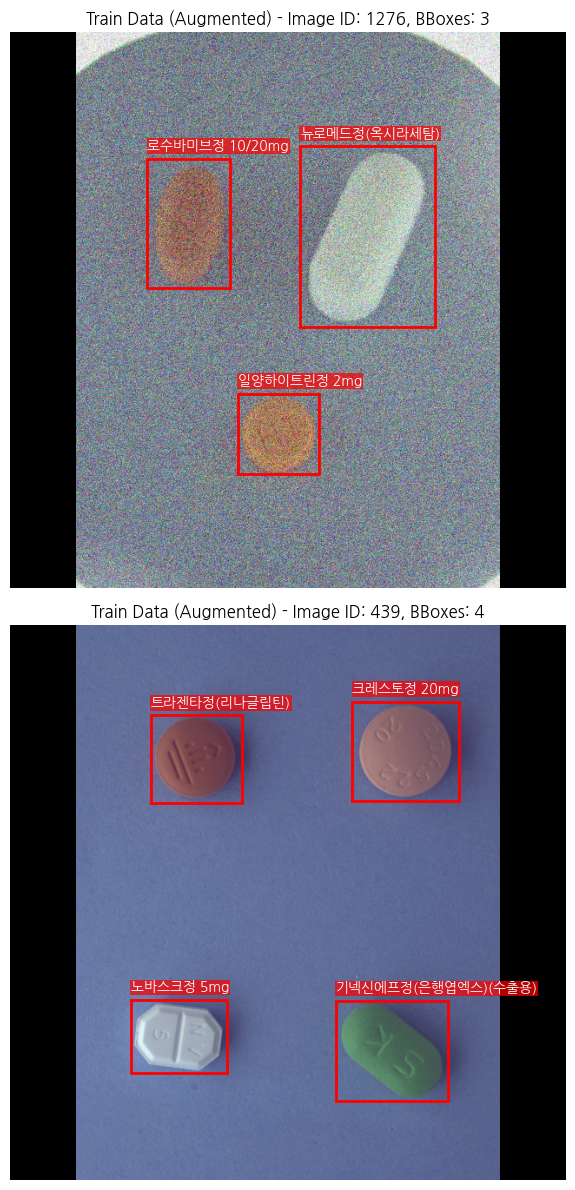


검증 데이터셋 샘플 시각화 (Albumentations 기본 변환):


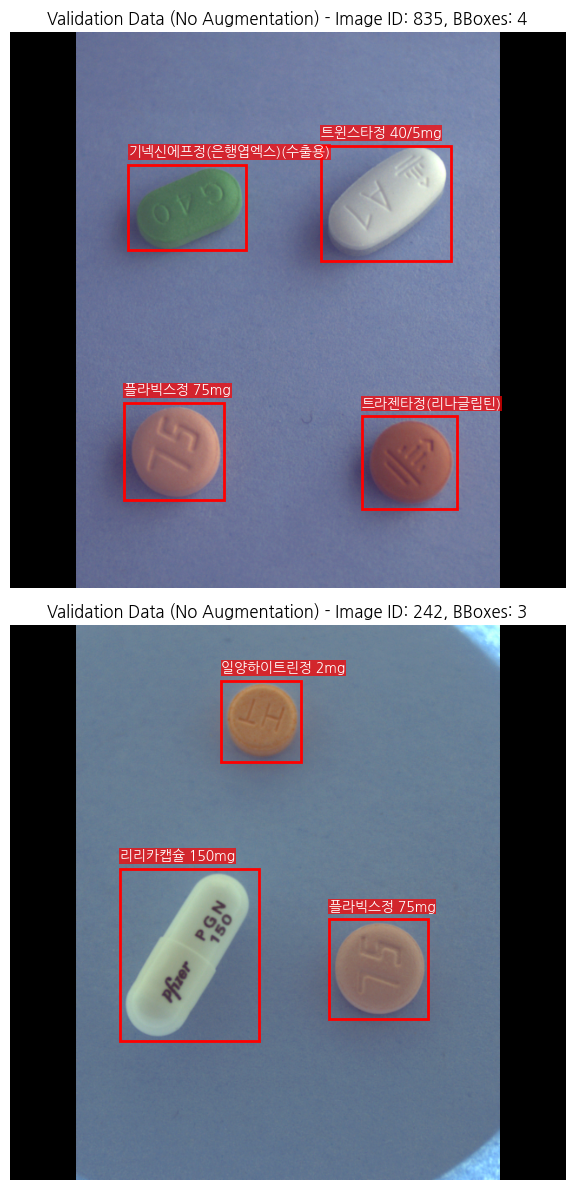

In [117]:
print("\n--- 전처리 및 증강 결과 시각화 (YOLOv8 바운딩 박스 포맷) ---")

def visualize_yolo_transformed_sample(dataset: torch.utils.data.Dataset, num_samples: int = 2, title_prefix: str = "Transformed YOLO Sample"):
    """
    YOLOv8 모델 입력용으로 전처리 및 증강된 이미지와 바운딩 박스 시각화
    
    Args:
        dataset (Dataset): 시각화할 PyTorch Dataset 인스턴스 (PillYoloDataset).
        num_samples (int): 시각화할 샘플 이미지의 개수.
        title_prefix (str): 서브플롯 제목의 접두사.
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6 * num_samples))
    if num_samples == 1:
        axes = [axes] # `num_samples`가 1개일 때 `axes`가 단일 객체이므로 리스트로 감싸 반복 가능하게 만듦

    for i in range(num_samples):
        # 데이터셋에서 랜덤으로 하나의 샘플 가져오기
        try:
            # PillYoloDataset.__getitem__은 image, labels_tensor, original_size를 반환
            random_dataset_idx = random.randint(0, len(dataset) - 1) # 데이터셋 내의 고유 인덱스
            image_tensor, labels_tensor, (orig_h, orig_w) = dataset[random_dataset_idx]
        except Exception as e:
            print(f"시각화 중 데이터 로딩 오류 발생 ({e}). 다른 샘플을 시도합니다.")
            continue

        # 이미지 텐서를 NumPy 배열로 변환 (PyTorch: CxHxW -> NumPy: HxWxC)
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        # 역정규화 (De-normalization)
        # 0-1 스케일링을 했으므로, 클리핑만 수행
        image_np = np.clip(image_np, 0, 1) # 픽셀 값을 0-1 범위로 클리핑하여 유효한 값 유지

        ax = axes[i]
        ax.imshow(image_np)
        
        # 바운딩 박스 그리기
        # `labels_tensor`의 각 행은 `[class_id, cx, cy, w, h]` (모두 0-1 정규화)
        # 이를 Matplotlib `Rectangle` 패치를 위해 픽셀 단위의 `[xmin, ymin, width, height]`로 변환
        
        # 현재 시각화되는 이미지의 실제 크기 (변환 후 이미지 크기)
        img_display_h, img_display_w = image_np.shape[:2]
        
        for j in range(len(labels_tensor)):
            class_id, cx, cy, w, h = labels_tensor[j].tolist()
            
            # YOLO 형식 (정규화) -> 픽셀 단위 (비정규화) -> COCO 형식 (xmin, ymin, width, height)
            xmin = int((cx - w / 2) * img_display_w)
            ymin = int((cy - h / 2) * img_display_h)
            width = int(w * img_display_w)
            height = int(h * img_display_h)
            
            label_id = int(class_id)
            class_name = category_id_to_name.get(label_id, f"Unknown_{label_id}")

            # 바운딩 박스 사각형 생성 및 추가
            rect = patches.Rectangle(
                (xmin, ymin), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            
            # 클래스 이름 텍스트 추가 (바운딩 박스 위쪽 또는 아래쪽)
            ax.text(xmin, ymin - 10 if ymin > 20 else ymin + height + 10, class_name,
                    color='white', fontsize=10,
                    bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', pad=0.5))
        
        # 시각화 제목 설정 (Image ID와 바운딩 박스 개수 포함)
        # PillYoloDataset.__getitem__은 image_id를 직접 반환하지 않으므로, dataset.image_ids[random_dataset_idx]로 접근
        ax.set_title(f"{title_prefix} - Image ID: {dataset.image_ids[random_dataset_idx]}, BBoxes: {len(labels_tensor)}")
        ax.axis('off') # 축 정보 제거

    plt.tight_layout() # 서브플롯 간의 간격 조정
    plt.show()

# --- 훈련 데이터셋 샘플 시각화 (Albumentations 증강이 적용된 상태) ---
print("\n훈련 데이터셋 샘플 시각화 (YOLOv8 증강 적용):")
visualize_yolo_transformed_sample(train_dataset, num_samples=2, title_prefix="Train Data (Augmented)")

# --- 검증 데이터셋 샘플 시각화 (Albumentations 기본 변환만 적용된 상태) ---
print("\n검증 데이터셋 샘플 시각화 (Albumentations 기본 변환):")
visualize_yolo_transformed_sample(val_dataset, num_samples=2, title_prefix="Validation Data (No Augmentation)")